In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/home/theo/kaggle/nfl_impact/src


## Imports

In [3]:
import os
import re
import cv2
import time
import torch
import imageio
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm
from skimage.transform import resize

In [4]:
from params import *

## Data

In [5]:
PATH = CROP_PATH_3D
DF_PATH = 'df_train_3d.csv'

### Load

In [6]:
df_train = pd.read_csv(DATA_PATH + DF_PATH)

In [7]:
df_train.dropna(inplace=True)

In [8]:
frame_impacts = df_train[["image_name", "extended_impact"]].groupby('image_name').max().reset_index()
frame_impacts = frame_impacts.rename(columns={"extended_impact": "frame_has_impact"})
df_train = df_train.merge(frame_impacts, on="image_name")

###  Aux target

In [10]:
# Single-label approach
aux_label = np.zeros((len(df_train)))

aux_label[df_train['extended_Helmet'] == 1] = 1
aux_label[df_train['extended_Shoulder'] == 1] = 2
aux_label[df_train['extended_shoulder'] == 1] = 2
aux_label[df_train['extended_Body'] == 1] = 2
aux_label[df_train['extended_Hand'] == 1] = 2
aux_label[df_train['extended_Ground'] == 1] = 3

df_train['aux_target'] = list(aux_label)

### Folds

In [11]:
folds = pd.read_csv(OUT_DIR + "folds.csv")
df_train = df_train.merge(folds, on="video")

## Dataset

In [12]:
from data.dataset import NFLDatasetCls3D
from data.transforms import get_transfos_cls

In [15]:
dataset = NFLDatasetCls3D(
    df_train.copy(),
    root=PATH,
    target_name='extended_impact',
    visualize=True
)

In [16]:
# for i in tqdm(range(len(dataset))):
#     image, y, y_aux = dataset[i]
#     assert image.shape == (9, 64, 64, 3)A

In [17]:
df_train['image_name'].unique()

array(['57583_000082_Endzone_0001.png', '57583_000082_Endzone_0002.png',
       '57583_000082_Endzone_0003.png', ...,
       '58107_004362_Sideline_0471.png', '58107_004362_Sideline_0472.png',
       '58107_004362_Sideline_0473.png'], dtype=object)

In [18]:
image, y, y_aux = dataset[0]

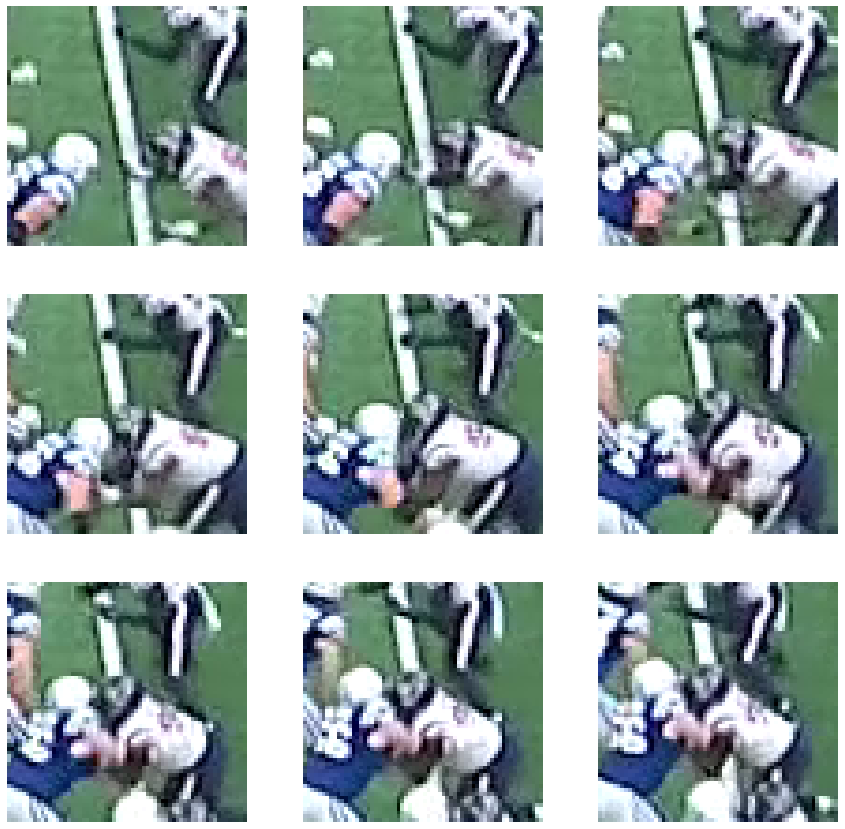

In [23]:
i = np.random.choice(len(dataset))

for i in np.random.choice(len(dataset), 10):
    image, y, y_aux = dataset[i]
    
    if y:
        plt.figure(figsize=(15, 15))
        for i, img in enumerate(image):
            if image.shape[0] == 9:
                plt.subplot(3, 3, i+1)
            else:
                plt.subplot(4, 5, i+1)
            plt.imshow(img)
            plt.axis(False)
        plt.show()

## Model

In [24]:
from model_zoo.models_cls_3d import get_model_cls_3d

../mmaction2/mmaction/models/backbones/resnet3d.py:18: UserWarning: Please install mmdet to use MMDET_SHARED_HEADS
  warnings.warn('Please install mmdet to use MMDET_SHARED_HEADS')
../mmaction2/mmaction/models/backbones/resnet3d_slowfast.py:17: UserWarning: Please install mmdet to use MMDET_BACKBONES
  warnings.warn('Please install mmdet to use MMDET_BACKBONES')
../mmaction2/mmaction/models/backbones/resnet3d_slowonly.py:10: UserWarning: Please install mmdet to use MMDET_BACKBONES
  warnings.warn('Please install mmdet to use MMDET_BACKBONES')
../mmaction2/mmaction/models/backbones/resnet_tin.py:12: UserWarning: Please install mmcv-full to support "tin_shift"
  warnings.warn('Please install mmcv-full to support "tin_shift"')
../mmaction2/mmaction/models/builder.py:11: UserWarning: Please install mmdet to use DETECTORS, build_detector
  warnings.warn('Please install mmdet to use DETECTORS, build_detector')
../mmaction2/mmaction/core/bbox/assigners/max_iou_assigner_ava.py:10: UserWarning:

In [25]:
# model = get_model_cls_3d('i3d', num_classes=1, num_classes_aux=5)
model = get_model_cls_3d('slowonly', num_classes=1, num_classes_aux=5)
# model = get_model_cls_3d('resnet50', num_classes=1, num_classes_aux=0)


 -> Loading weighs from "../input/weights/slowonly_r50_omni_4x16x1_kinetics400_rgb.pth"



In [26]:
x = torch.randn(1, 3, 9, 64, 64)

In [27]:
model(x)

(tensor([[-0.1127]], grad_fn=<AddmmBackward>),
 tensor([[ 0.2614, -0.0135,  0.0902,  0.3384,  0.1753]],
        grad_fn=<AddmmBackward>))

## Training

In [29]:
from training.main_cls_3d import k_fold_cls_3d

In [30]:
from utils.logger import prepare_log_folder, save_config, create_logger

In [31]:
BATCH_SIZES = {
    "i3d": 32,
    "slowfast": 64,
    "slowonly": 32,
    "resnet18": 128,
    "resnet34": 64,
    "resnet50": 32,
}

In [32]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    img_path = PATH
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True
    
    # Target
    target_name = "extended_impact"

    # k-fold
    k = 5
    random_state = 0
    selected_folds = [0, 1, 2, 3, 4]

    # Model
    name = "i3d"  #'slowonly', "slowfast", "resnet18", "resnet34"
    num_classes = 1
    
    aux_mode = "softmax"
#     num_classes_aux = 4 if aux_mode == "softmax" else 3
    num_classes_aux = 0

    # Training       
    batch_size = BATCH_SIZES[name]
    samples_per_player = 4 #int(1 / 32 * batch_size)
    optimizer = "Adam"
    
    acc_steps = 1
    epochs = 20 if samples_per_player else 4
    swa_first_epoch = 15

    lr = 5e-4  # 5e-4 / 1e-3
    warmup_prop = 0.05
    val_bs = batch_size * 2
    
    first_epoch_eval = 20

In [33]:
DEBUG = True
log_folder = None

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH_CLS_3D)
    print(f'Logging results to {log_folder}')
    config_df = save_config(Config, log_folder + 'config.json')
    create_logger(directory=log_folder, name="logs.txt")
    
    warnings.filterwarnings("ignore")

pred_oof = k_fold_cls_3d(
    Config,
    df_train,
    log_folder=log_folder
)


-------------   Fold 1 / 5  -------------


 -> Loading weights from ../input/weights/rgb_imagenet.pt

    -> 154983 training images
    -> 38748 validation images
    -> 12288289 trainable parameters

Using 254 out of 4843 batches by limiting to 4 samples per player.

Epoch 01/20 	 lr=5.0e-04	 t=120s 	loss=0.356	
Epoch 02/20 	 lr=4.7e-04	 t=122s 	loss=0.225	
Epoch 03/20 	 lr=4.5e-04	 t=122s 	loss=0.186	
